# Purpose
Our goal with this project was initially to see if we could predict what makes a player “good” in the NFL. We planned to do this by objectively claiming “good” was a player who had played in the league for a long time. The goal was to use both numerical statistics (such as passes, rushing yards, interceptions, etc.) and biographical data (height, weight, college attended, etc.) to try and draw a correlation with the number of seasons that a player played. The error with this is that it does not take into account injuries, personal matters, or matters out of a player’s control such as collective bargaining disagreements, political moves, and team relocations.

The project we actually did was an attempt to use the same statistics as before, but use them in order to try and predict a player’s position. This seemed to be a good goal given our data set as a majority of players in the data set were given statistics and biographical data, but not given a position. 

Our experiment is useful for any players at the high school or collegiate level who are wish to play a specific position by showing them skills they should try to perfect. Attributes such as height and birthplace are out of a player’s control, but a player can control weight, arm strength (for passing distance), or leg strength (for net punting yards).


In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import urllib2
import urllib
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import json
import re
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier

In [38]:

Basic_Stats = pd.read_csv("./Basic_Stats.csv");
Basic_Stats = pd.DataFrame(data = Basic_Stats)

print Basic_Stats.info(), "\n\n"
Basic_Stats['Current Team'].replace(np.nan,'Retired', inplace=True);
Basic_Stats['Years Played'].replace(np.nan,'Active', inplace=True);

#Assign positions to positional groups

Basic_Stats['Position'].replace(['QB'],0, inplace=True);
Basic_Stats['Position'].replace(['RB','FB'],1, inplace=True);
Basic_Stats['Position'].replace(['WR','TE'],2, inplace=True);
Basic_Stats['Position'].replace(['OL','OG','G','C','T','OT'],3, inplace=True);
Basic_Stats['Position'].replace(['DE','DT','NT','DL'],4, inplace=True);
Basic_Stats['Position'].replace(['OLB', 'ILB','LB','MLB'],5, inplace=True);
Basic_Stats['Position'].replace(['SS','FS','SAF','LS','CB','DB'],6, inplace=True);
Basic_Stats['Position'].replace(['K','P'],7, inplace=True);


#Delete sparse data 
Basic_Stats = Basic_Stats.drop(['Number'], axis=1)
Basic_Stats = Basic_Stats.drop(['High School'], axis=1)
Basic_Stats = Basic_Stats.drop(['High School Location'], axis=1)
Basic_Stats = Basic_Stats.drop(['Age'], axis=1)
Basic_Stats = Basic_Stats.dropna(axis = 0, how="any")
Data = Basic_Stats.drop(['Position'], axis=1)
#Turn experience column into int64 data type by removing "Seasons"
Basic_Stats['Experience'] = pd.Series(Basic_Stats['Experience']).str.replace(' Seasons', '')
Basic_Stats['Experience'] = pd.to_numeric(Basic_Stats['Experience'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17172 entries, 0 to 17171
Data columns (total 16 columns):
Age                     13504 non-null float64
Birth Place             14794 non-null object
Birthday                16835 non-null object
College                 17133 non-null object
Current Status          17172 non-null object
Current Team            3096 non-null object
Experience              17133 non-null object
Height (inches)         17026 non-null float64
High School             2514 non-null object
High School Location    2510 non-null object
Name                    17172 non-null object
Number                  1708 non-null float64
Player Id               17172 non-null object
Position                3096 non-null object
Weight (lbs)            17121 non-null float64
Years Played            14076 non-null object
dtypes: float64(4), object(12)
memory usage: 2.1+ MB
None 




Correlations:
                   Experience  Height (inches)  Position  Weight (lbs)
Experience         1.000000         0.001622  0.035509      0.063097
Height (inches)    0.001622         1.000000 -0.177665      0.701241
Position           0.035509        -0.177665  1.000000     -0.142745
Weight (lbs)       0.063097         0.701241 -0.142745      1.000000 


[[ 1.          0.70124147]
 [ 0.70124147  1.        ]]
[[ 1.         -0.17766542]
 [-0.17766542  1.        ]]


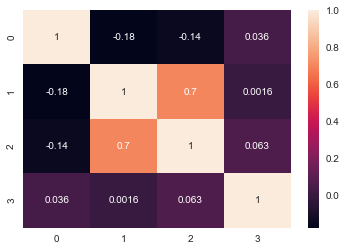

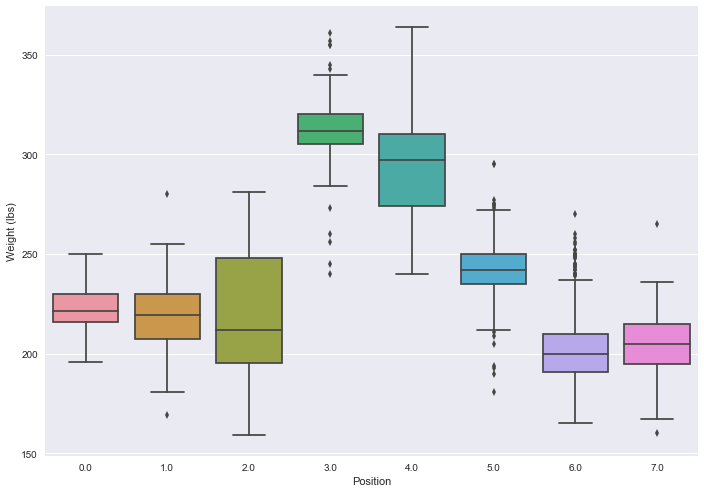

In [39]:
print "Correlations:\n ",Basic_Stats.corr(method='pearson'), "\n\n"

HeightWeight = np.corrcoef(Basic_Stats['Weight (lbs)'],Basic_Stats['Height (inches)'])
print HeightWeight;

HeightPosition = np.corrcoef(Basic_Stats['Position'],Basic_Stats['Height (inches)'])
print HeightPosition;

coef = np.corrcoef([Basic_Stats['Position'],Basic_Stats['Height (inches)'],Basic_Stats['Weight (lbs)'],Basic_Stats['Experience']])
plt.plot(figsize=(10,10))
sns.heatmap(coef, annot=True)

#Box plot of Weight ranges for each position
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.figure()
sns.boxplot(x="Position", y="Weight (lbs)", data=Basic_Stats);
plt.figure()



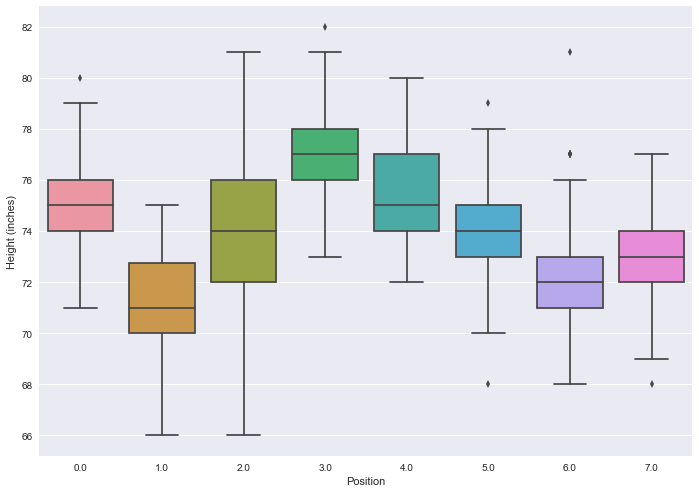

In [40]:
sns.boxplot(x="Position", y="Height (inches)", data=Basic_Stats);
plt.figure()



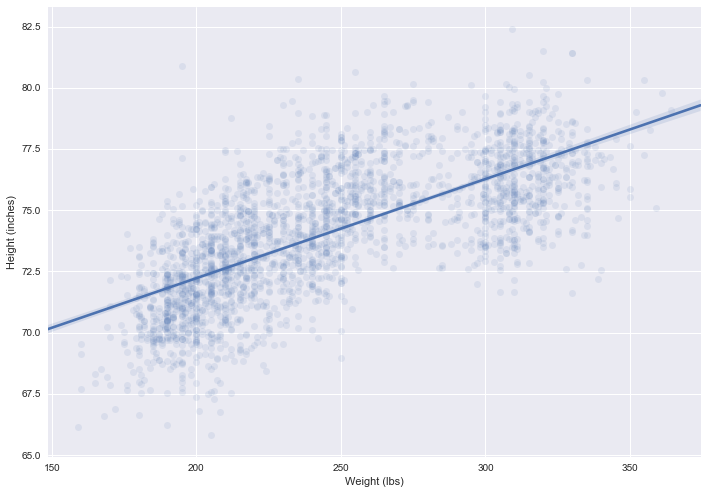

In [41]:
sns.regplot(x="Weight (lbs)", y="Height (inches)", data=Basic_Stats, y_jitter=.5, scatter_kws={'alpha':0.1});
plt.figure()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2514 entries, 4 to 17157
Data columns (total 12 columns):
Birth Place        2514 non-null object
Birthday           2514 non-null object
College            2514 non-null object
Current Status     2514 non-null object
Current Team       2514 non-null object
Experience         2514 non-null int64
Height (inches)    2514 non-null float64
Name               2514 non-null object
Player Id          2514 non-null object
Position           2514 non-null float64
Weight (lbs)       2514 non-null float64
Years Played       2514 non-null object
dtypes: float64(3), int64(1), object(8)
memory usage: 335.3+ KB
None 




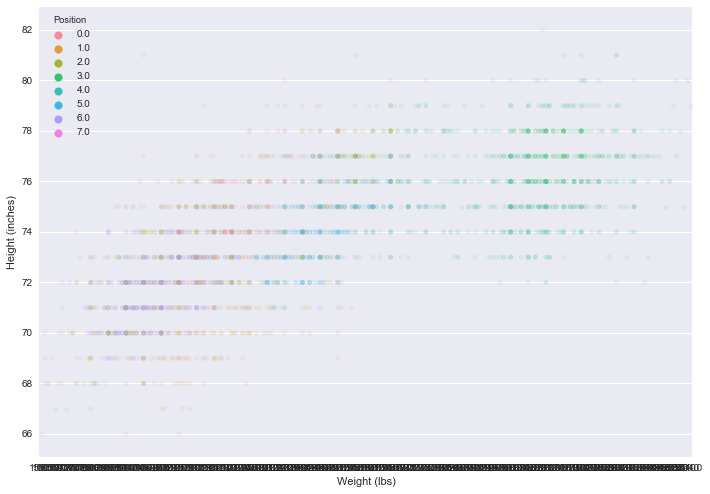

In [42]:
sns.stripplot(x="Weight (lbs)", y="Height (inches)", data=Basic_Stats, hue = 'Position', alpha=0.1);
print Basic_Stats.info(), "\n\n"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4302 entries, 0 to 4301
Data columns (total 7 columns):
Player Id           4302 non-null object
Games Played        4302 non-null int64
Total Tackles       4302 non-null int64
Solo Tackles        4302 non-null int64
Assisted Tackles    4302 non-null int64
Sacks               4302 non-null float64
Ints                4302 non-null int64
dtypes: float64(1), int64(5), object(1)
memory usage: 235.3+ KB
None


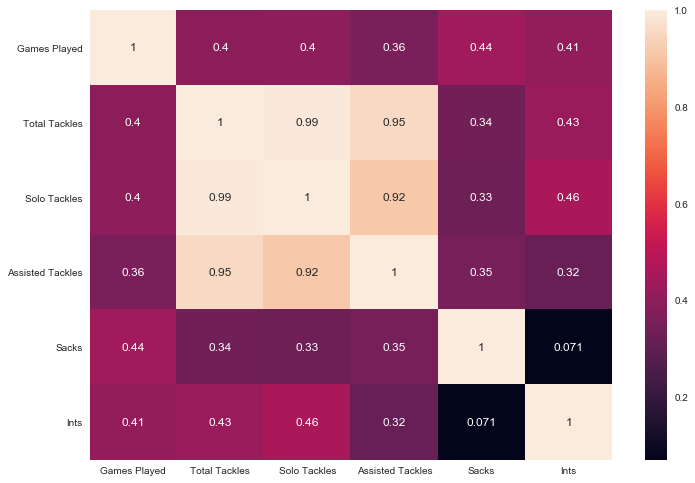

In [43]:
"""
Standardize Defensive Career Stats and Group By Player ID
"""
Defensive_Stats = pd.read_csv("./Career_Stats_Defensive.csv");
Defensive_Stats = Defensive_Stats.drop(['Name'], axis=1)
Defensive_Stats = Defensive_Stats.drop(['Position'], axis=1)
Defensive_Stats = Defensive_Stats.drop(['Year'], axis=1)
Defensive_Stats = Defensive_Stats.drop(['Team'], axis=1)
Defensive_Stats['Total Tackles'].replace('--',0, inplace=True);
Defensive_Stats['Total Tackles'] = pd.to_numeric(Defensive_Stats['Total Tackles'])
Defensive_Stats['Solo Tackles'].replace('--',0, inplace=True);
Defensive_Stats['Solo Tackles'] = pd.to_numeric(Defensive_Stats['Solo Tackles'])
Defensive_Stats['Assisted Tackles'].replace('--',0, inplace=True);
Defensive_Stats['Assisted Tackles'] = pd.to_numeric(Defensive_Stats['Assisted Tackles'])
Defensive_Stats['Sacks'].replace('--',0, inplace=True);
Defensive_Stats['Sacks'] = pd.to_numeric(Defensive_Stats['Sacks'])
Defensive_Stats['Ints'].replace('--',0, inplace=True);
Defensive_Stats['Ints'] = pd.to_numeric(Defensive_Stats['Ints'])
Defensive_Stats = Defensive_Stats[Defensive_Stats.columns.drop(list(Defensive_Stats.filter(regex='Per')))]
Defensive_Stats = Defensive_Stats.groupby(Defensive_Stats['Player Id']).sum()
Defensive_Stats.reset_index(level=0, inplace=True)
Defensive_Coef = Defensive_Stats.corr()
plt.plot(figsize=(10,10))
sns.heatmap(Defensive_Coef, annot=True)
print Defensive_Stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1323 entries, 0 to 1322
Data columns (total 12 columns):
Player Id                      1323 non-null object
Games Played                   1323 non-null int64
Passes Attempted               1323 non-null int64
Passes Completed               1323 non-null int64
TD Passes                      1323 non-null int64
Ints                           1323 non-null int64
Int Rate                       1323 non-null float64
Passes Longer than 20 Yards    1323 non-null int64
Passes Longer than 40 Yards    1323 non-null int64
Sacks                          1323 non-null int64
Sacked Yards Lost              1323 non-null int64
Passer Rating                  1323 non-null float64
dtypes: float64(2), int64(9), object(1)
memory usage: 124.1+ KB
None


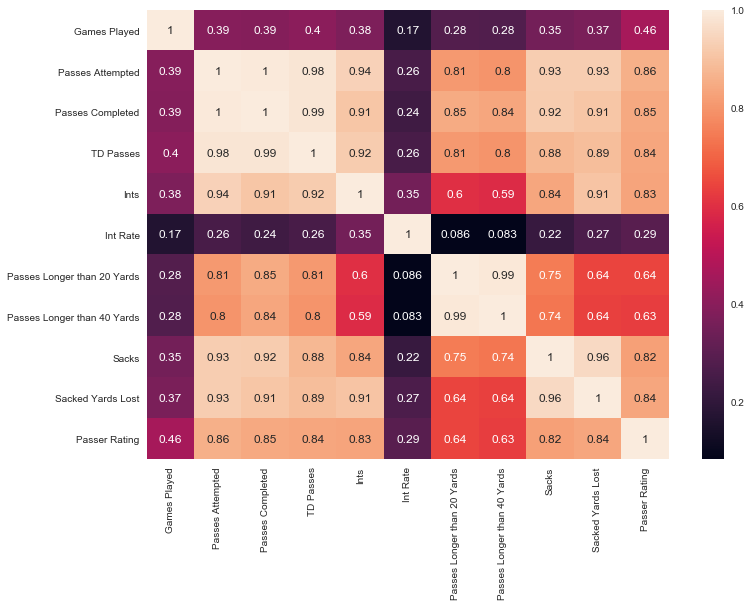

In [44]:
"""
Standardize Passing Stats
"""
Passing_Stats = pd.read_csv("./Career_Stats_Passing.csv");
Passing_Stats = Passing_Stats.drop(['Name'], axis=1)
Passing_Stats = Passing_Stats.drop(['Position'], axis=1)
Passing_Stats = Passing_Stats.drop(['Year'], axis=1)
Passing_Stats = Passing_Stats.drop(['Team'], axis=1)
Passing_Stats = Passing_Stats.drop(['Completion Percentage'], axis=1)
Passing_Stats = Passing_Stats[Passing_Stats.columns.drop(list(Passing_Stats.filter(regex='Per')))]
Passing_Stats = Passing_Stats.groupby(Passing_Stats['Player Id']).sum()
Passing_Stats.reset_index(level=0, inplace=True)
Passing_Coef = Passing_Stats.corr()
plt.plot(figsize=(10,10))
sns.heatmap(Passing_Coef, annot=True)
print Passing_Stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3577 entries, 0 to 3576
Data columns (total 8 columns):
Player Id                          3577 non-null object
Games Played                       3577 non-null int64
Receptions                         3577 non-null int64
Receiving TDs                      3577 non-null int64
Receptions Longer than 20 Yards    3577 non-null int64
Receptions Longer than 40 Yards    3577 non-null int64
First Down Receptions              3577 non-null int64
Fumbles                            3577 non-null int64
dtypes: int64(7), object(1)
memory usage: 223.6+ KB
None


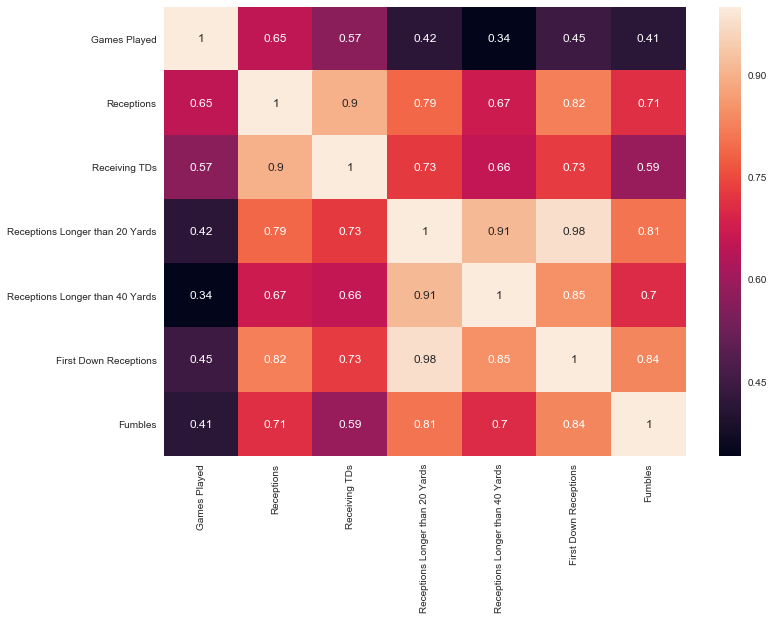

In [45]:
"""
Standardizes Receiving Stats
"""
Receiving_Stats = pd.read_csv("./Career_Stats_Receiving.csv");
Receiving_Stats = Receiving_Stats.drop(['Name'], axis=1)
Receiving_Stats = Receiving_Stats.drop(['Position'], axis=1)
Receiving_Stats = Receiving_Stats.drop(['Year'], axis=1)
Receiving_Stats = Receiving_Stats.drop(['Team'], axis=1)
Receiving_Stats = Receiving_Stats.groupby(Receiving_Stats['Player Id']).sum()
Receiving_Stats = Receiving_Stats[Receiving_Stats.columns.drop(list(Receiving_Stats.filter(regex='Per')))]
Receiving_Stats.reset_index(level=0, inplace=True)
Receiving_Coef = Receiving_Stats.corr()
plt.plot(figsize=(10,10))
sns.heatmap(Receiving_Coef, annot=True)
print Receiving_Stats.info()



In [46]:
"""
Standardizes Offensive Line Stats
OL Might need to be dropped due to lack of stats unless Height and Weight play key factors in linemen
"""
Offensive_Line_Stats = pd.read_csv("./Career_Stats_Offensive_Line.csv");
Offensive_Line_Stats = Offensive_Line_Stats.drop(['Name'], axis=1)
Offensive_Line_Stats = Offensive_Line_Stats.drop(['Position'], axis=1)
Offensive_Line_Stats = Offensive_Line_Stats.drop(['Year'], axis=1)
Offensive_Line_Stats = Offensive_Line_Stats.drop(['Team'], axis=1)
Offensive_Line_Stats = Offensive_Line_Stats.groupby(Offensive_Line_Stats['Player Id']).sum()
Offensive_Line_Stats = Offensive_Line_Stats[Offensive_Line_Stats.columns.drop(list(Offensive_Line_Stats.filter(regex='Per')))]
Offensive_Line_Stats.reset_index(level=0, inplace=True)

print Offensive_Line_Stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2885 entries, 0 to 2884
Data columns (total 3 columns):
Player Id        2885 non-null object
Games Played     2885 non-null int64
Games Started    2885 non-null int64
dtypes: int64(2), object(1)
memory usage: 67.7+ KB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182 entries, 0 to 181
Data columns (total 10 columns):
Player Id                    182 non-null object
Games Played                 182 non-null int64
Kickoffs                     182 non-null int64
Out of Bounds Kickoffs       182 non-null int64
Touchbacks                   182 non-null int64
Kickoffs Returned            182 non-null int64
Average Returned Yards       182 non-null float64
Kickoffs Resulting in TDs    182 non-null int64
On Sides Kicks               182 non-null int64
On Sides Kicks Returned      182 non-null int64
dtypes: float64(1), int64(8), object(1)
memory usage: 14.3+ KB
None


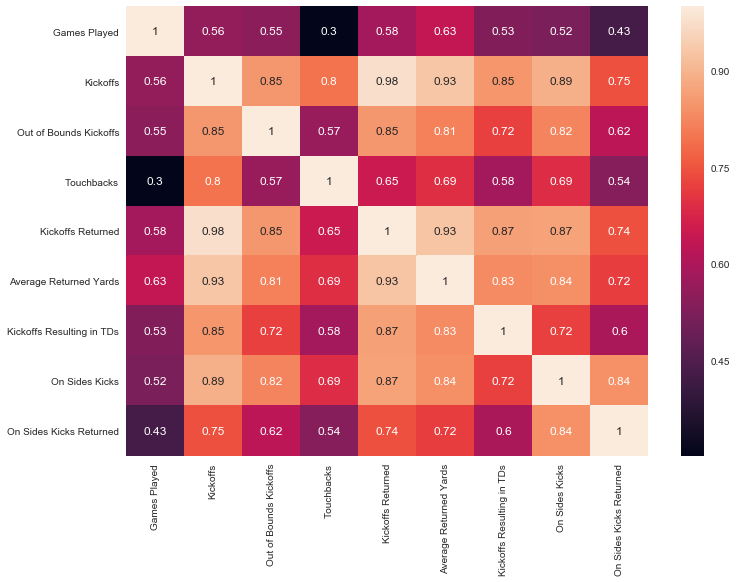

In [47]:
"""
Standardizes Kicker Stats
"""
Kicker_Stats = pd.read_csv("./Career_Stats_Kickoff.csv");
Kicker_Stats = Kicker_Stats.drop(['Name'], axis=1)
Kicker_Stats = Kicker_Stats.drop(['Position'], axis=1)
Kicker_Stats = Kicker_Stats.drop(['Year'], axis=1)
Kicker_Stats = Kicker_Stats.drop(['Team'], axis=1)
Kicker_Stats = Kicker_Stats.groupby(Kicker_Stats['Player Id']).sum()
Kicker_Stats = Kicker_Stats[Kicker_Stats.columns.drop(list(Kicker_Stats.filter(regex='Per')))]
Kicker_Stats.reset_index(level=0, inplace=True)
Kicker_Coef = Kicker_Stats.corr()
plt.plot(figsize=(10,10))
sns.heatmap(Kicker_Coef, annot=True)
print Kicker_Stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463 entries, 0 to 462
Data columns (total 15 columns):
Player Id                    463 non-null object
Games Played                 463 non-null int64
Punts                        463 non-null int64
Longest Punt                 463 non-null int64
Gross Punting Average        463 non-null float64
Net Punting Average          463 non-null float64
Punts Blocked                463 non-null int64
Out of Bounds Punts          463 non-null int64
Downed Punts                 463 non-null int64
Punts Inside 20 Yard Line    463 non-null int64
Touchbacks                   463 non-null int64
Fair Catches                 463 non-null int64
Punts Returned               463 non-null int64
Yards Returned on Punts      463 non-null int64
TDs Returned on Punt         463 non-null int64
dtypes: float64(2), int64(12), object(1)
memory usage: 54.3+ KB
None


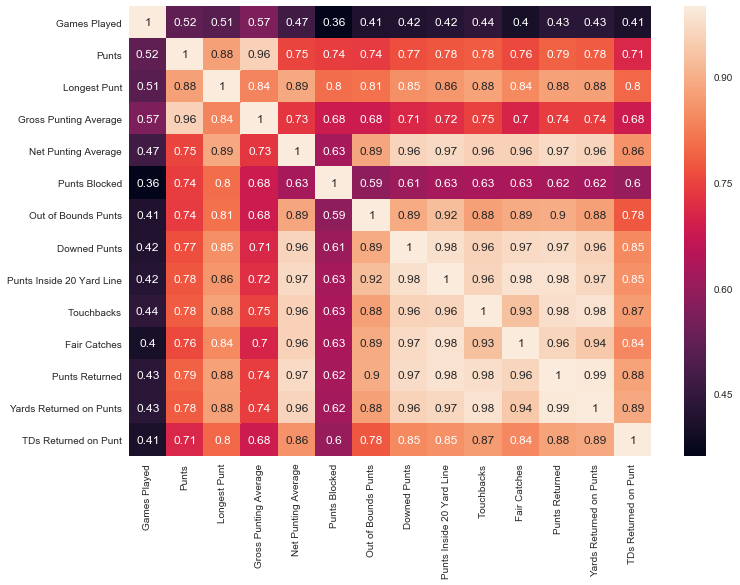

In [48]:
"""
Standardizes Punter Stats
"""
Punter_Stats = pd.read_csv("./Career_Stats_Punting.csv");
Punter_Stats = Punter_Stats.drop(['Name'], axis=1)
Punter_Stats = Punter_Stats.drop(['Position'], axis=1)
Punter_Stats = Punter_Stats.drop(['Year'], axis=1)
Punter_Stats = Punter_Stats.drop(['Team'], axis=1)
Punter_Stats = Punter_Stats.groupby(Punter_Stats['Player Id']).sum()
Punter_Stats = Punter_Stats[Punter_Stats.columns.drop(list(Punter_Stats.filter(regex='Per')))]
Punter_Stats.reset_index(level=0, inplace=True)
Punter_Coef = Punter_Stats.corr()
plt.plot(figsize=(10,10))
sns.heatmap(Punter_Coef, annot=True)
print Punter_Stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3190 entries, 0 to 3189
Data columns (total 8 columns):
Player Id                     3190 non-null object
Games Played                  3190 non-null int64
Rushing Attempts              3190 non-null int64
Rushing TDs                   3190 non-null int64
Rushing First Downs           3190 non-null int64
Rushing More Than 20 Yards    3190 non-null int64
Rushing More Than 40 Yards    3190 non-null int64
Fumbles                       3190 non-null int64
dtypes: int64(7), object(1)
memory usage: 199.4+ KB
None


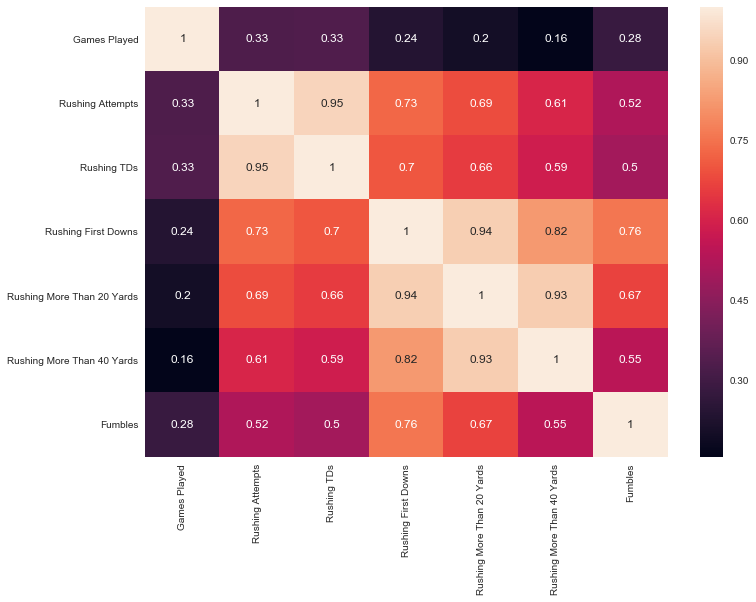

In [49]:
"""
Standardizes Rusher Stats
"""
Rusher_Stats = pd.read_csv("./Career_Stats_Rushing.csv");
Rusher_Stats = Rusher_Stats.drop(['Name'], axis=1)
Rusher_Stats = Rusher_Stats.drop(['Position'], axis=1)
Rusher_Stats = Rusher_Stats.drop(['Year'], axis=1)
Rusher_Stats = Rusher_Stats.drop(['Team'], axis=1)
Rusher_Stats = Rusher_Stats.groupby(Rusher_Stats['Player Id']).sum()
Rusher_Stats = Rusher_Stats[Rusher_Stats.columns.drop(list(Rusher_Stats.filter(regex='Per')))]
Rusher_Stats.reset_index(level=0, inplace=True)
Rusher_Coef = Rusher_Stats.corr()
plt.plot(figsize=(10,10))
sns.heatmap(Rusher_Coef, annot=True)
print Rusher_Stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18436 entries, 4 to 4301
Data columns (total 40 columns):
Assisted Tackles                   18436 non-null float64
Average Returned Yards             18436 non-null float64
Downed Punts                       18436 non-null float64
Fair Catches                       18436 non-null float64
First Down Receptions              18436 non-null float64
Gross Punting Average              18436 non-null float64
Height (inches)                    18436 non-null float64
Int Rate                           18436 non-null float64
Ints                               18436 non-null float64
Kickoffs                           18436 non-null float64
Kickoffs Resulting in TDs          18436 non-null float64
Kickoffs Returned                  18436 non-null float64
Longest Punt                       18436 non-null float64
On Sides Kicks                     18436 non-null float64
On Sides Kicks Returned            18436 non-null float64
Out of Bounds Kickoffs

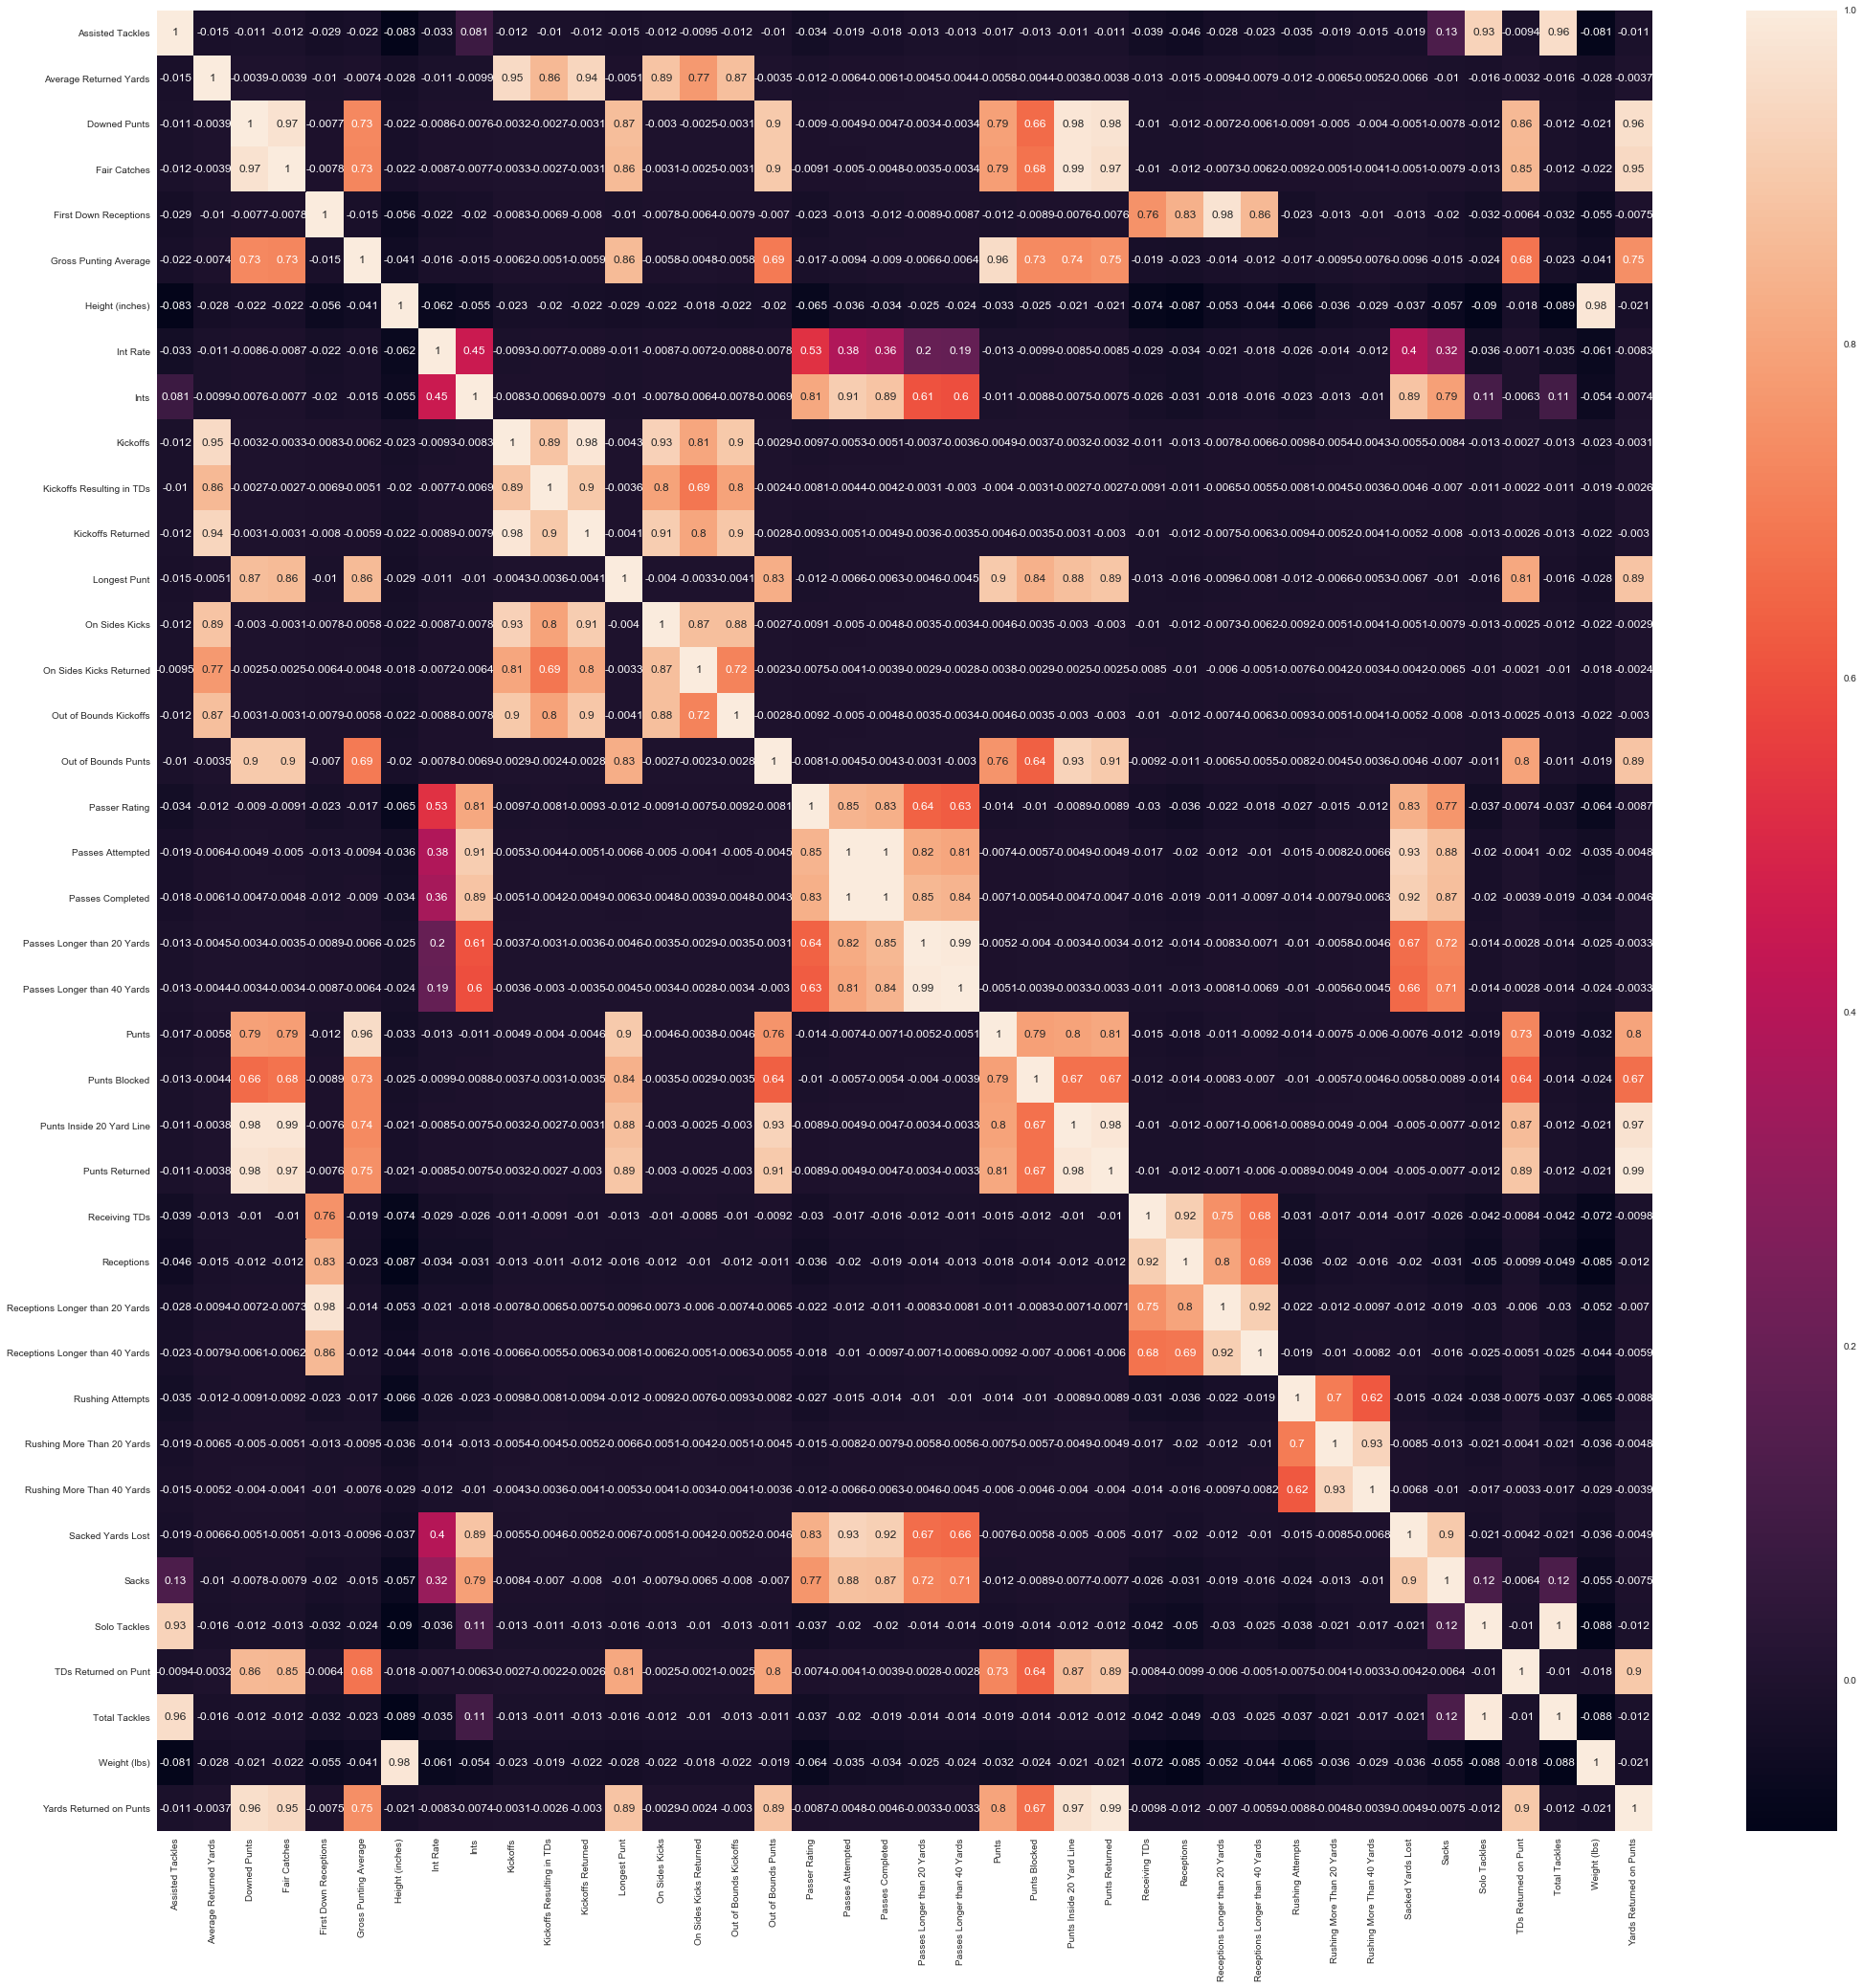

In [50]:
"""
Merge all data frames into one massive one based on player ID
"""
Statistics = pd.concat([Basic_Stats, Passing_Stats,Rusher_Stats,Kicker_Stats,Punter_Stats,Offensive_Line_Stats,Receiving_Stats,Defensive_Stats])
Statistics = Statistics.fillna(0)
#Need to replace all NaN Statistics values with 0
#df = Statistics.drop(['Games Played', 'Games Started','Height (inches)', 'Weight (lbs)','Experience','Birth Place', 'Birthday','College','Current Status','Current Team','Name','Years Played','Player Id','Position'], axis=1)
df = Statistics.drop(['Games Played', 'Games Started','Experience','Birth Place', 'Birthday','College','Current Status','Current Team','Name','Years Played','Player Id','Position','Rushing TDs','Rushing First Downs','Net Punting Average','Touchbacks','TD Passes','Fumbles'], axis=1)
#Don't delete above line - SAM
Overall_Coef = df.corr()
plt.subplots(figsize=(35,35))
sns.heatmap(Overall_Coef, annot=True)
target = Statistics['Position']
print df.info()


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


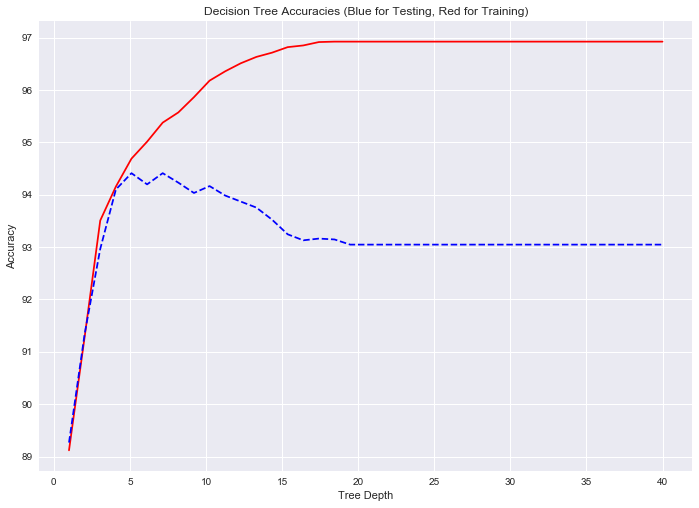

In [51]:
from sklearn.model_selection import train_test_split

n_train = 10000
print type(df)
if not isinstance(target, pd.DataFrame):
    target = target.to_frame(name='position')
print type(target)
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(df, target, test_size=0.33)
#X_train_tree, y_train_tree = df[:n_train, :], target[:n_train]
#y_train_tree = y_train_tree.astype('float')
#X_test_tree, y_test_tree = df[n_train:, :], target[n_train:]
#y_test_tree = y_test_tree.astype('int')

treeTrainScores =[]
treeTestScores=[]
treeIters = np.linspace(1, 40, 39, endpoint=True)
for i in range(1,40,1):
    clf = tree.DecisionTreeClassifier(max_depth=i)
    clf1 = clf.fit(X_train_tree, y_train_tree)
    treeTrainScores.append(clf1.score(X_train_tree, y_train_tree)*100)
    #clf2 = clf.fit(X_test_tree, y_test_tree)
    treeTestScores.append(clf1.score(X_test_tree, y_test_tree)*100)
plt.plot(treeIters,treeTrainScores, 'r', label="Training")
plt.plot(treeIters,treeTestScores,'b--', label="Testing")
plt.title("Decision Tree Accuracies (Blue for Testing, Red for Training)")
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.show()



Accuracy Scores with a tree depth of 12:
 - Non CV score:  0.952576754386
 - Cross Validated Accuracy : 93.34% (+/- 2.70%)


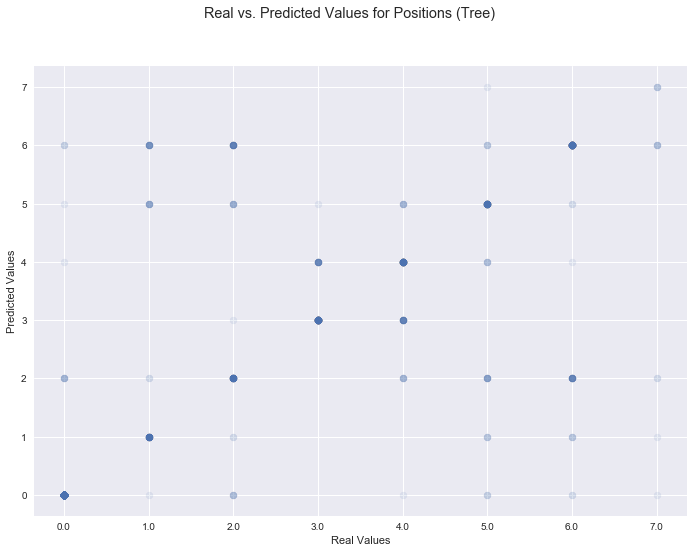

In [52]:
clf = tree.DecisionTreeClassifier(max_depth=12)
clf1 = clf.fit(X_train_tree, y_train_tree)
predictedVals = clf1.predict(Test_X);
plt.scatter(Test_Y, predictedVals, alpha = .1)
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.suptitle("Real vs. Predicted Values for Positions (Tree)")
print "Accuracy Scores with a tree depth of 12:"
print " - Non CV score: ",clf1.score(Test_X, Test_Y)
scores = cross_val_score(clf1, Test_X, Test_Y, cv=5)
print(" - Cross Validated Accuracy : %0.2f%% (+/- %0.2f%%)" % (scores.mean()*100, (scores.std() * 2)*100))

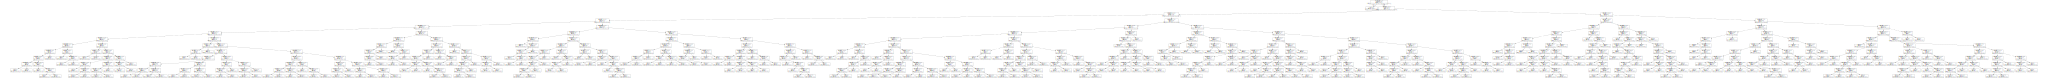

In [53]:
#do "conda install python-graphviz" command in terminal
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None,feature_names=list(X_train_tree.columns.values)) 
graph = graphviz.Source(dot_data) 
graph

# Tree Interpretation

Using a Decision Tree algorithm for classifying players into positions seemed to work quite well. Many players could be sorted into a correct category based on majority voting chance at a lower tree depth, while players were sorted with over 93% testing accuracy into their correct positions when the tree depth was greater than 9 levels. The accuracy started leveling off around a depth of 15 which leads us to believe that we should set our max depth slightly below this level in order to avoid overfitting the data. As seen in the real vs predicted values chart, this method is extremely good at predicting positions compared to the other models. This is shown because the corresponding dots for each position (IE X=2.0, Y=2.0) are much darker than other dots on the graph. One curious thing to notice is the high level of predictions in which the player is actually a receiver, but the decision tree predicts the player to be a defensive back. This is likely because both positions require tall, fast players who are capable of catching passes and these players are often used to return punts and kickoffs (which are both statistics in our data set).


In [17]:
#Prepares the training and testing sets of data for the regression models
train_test_split = 0.8
msk = np.random.rand(len(df)) < train_test_split
Train_X = df[msk]
Train_Y = target[msk]
Test_X = df[~msk]
Test_Y = target[~msk]

C:\Users\Kevin\Anaconda2\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Non-CV score:  0.920230263158
Cross Validated Accuracy : 93.04% (+/- 3.43%)


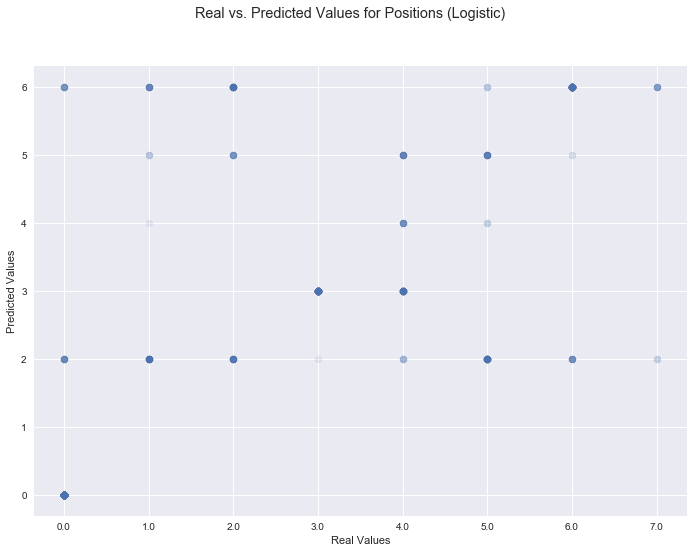

In [54]:
#Logistic Regression
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
logistic.fit(Train_X, Train_Y);
predictedVals = logistic.predict(Test_X);
plt.scatter(Test_Y, predictedVals, alpha = .1)
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.suptitle("Real vs. Predicted Values for Positions (Logistic)")
print "Non-CV score: ", logistic.score(Test_X, Test_Y);
scores = cross_val_score(logistic, Test_X, Test_Y, cv=5)
print("Cross Validated Accuracy : %0.2f%% (+/- %0.2f%%)" % (scores.mean()*100, (scores.std() * 2)*100))

0.768641192742
Cross Validated Accuracy : -26.89% (+/- 107.58%)


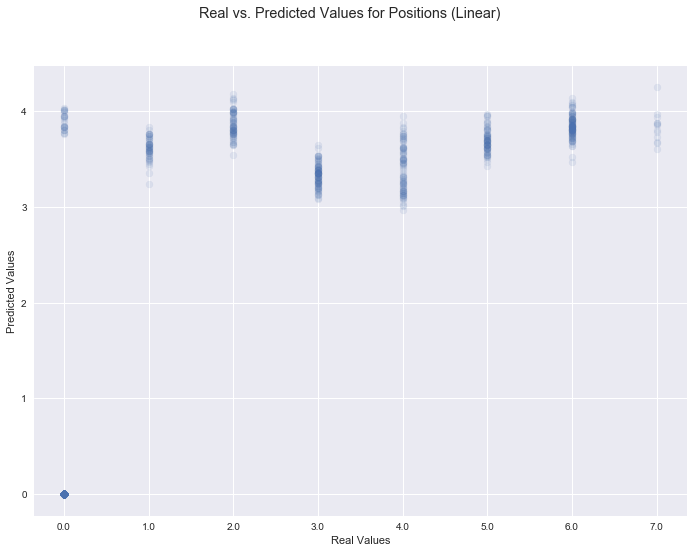

In [55]:
#Multiple Linear Regression
from sklearn import linear_model
LR = linear_model.LinearRegression();
LR.fit(Train_X, Train_Y);
predictedVals = LR.predict(Test_X);
plt.scatter(Test_Y, predictedVals, alpha = .1)
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.suptitle("Real vs. Predicted Values for Positions (Linear)")
print LR.score(Test_X, Test_Y)
scores = cross_val_score(LR, Test_X, Test_Y, cv=5)
print("Cross Validated Accuracy : %0.2f%% (+/- %0.2f%%)" % (scores.mean()*100, (scores.std() * 2)*100))

# Logistic and MLR Regression Interpretations

Logistic regression was an accurate method of predicting player positions based on the data set. 80% of the data was used for training while 20% was used for the testing. We also ran cross validation scoring on both models. The logistic regression model appeared to be accurate both when cross-validated and when not cross-validated. The Multiple Linear Regression technique was not accurate for non-cross-validation, and was given a negative accuracy rating for cross-validation. Thus we conclude that we should not use MLR to classify our data. As we can see from the plots of actual values vs. predicted values, both models do a poor job of classifying kickers/punters (category 7). However, based on the darkness of the dots in the logistic regression plot, we can see that the model often does predict the categories correctly.

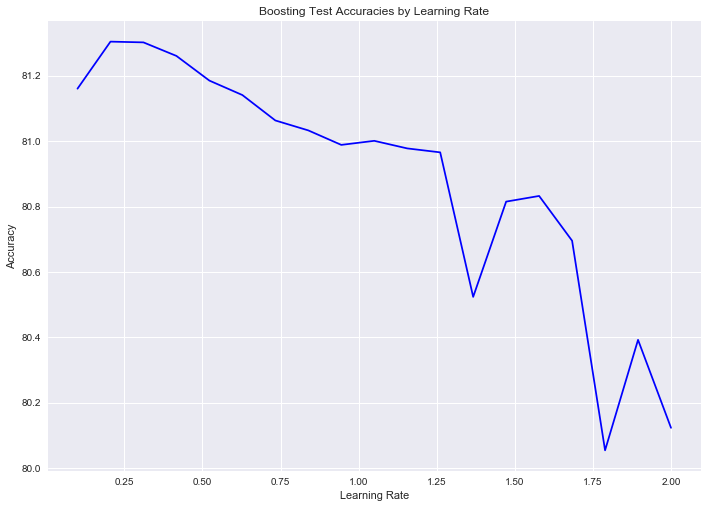

In [56]:
from sklearn.ensemble import GradientBoostingRegressor
gradientTestScores=[]

gradientIters = np.linspace(.1, 2, 19, endpoint=True)

for i in range(1,20,1):
    est = GradientBoostingRegressor(n_estimators=1000, max_depth=1, learning_rate=(i/10.0))
    est.fit(Train_X, Train_Y)
    gradientTestScores.append(est.score(Test_X, Test_Y)*100)
plt.plot(gradientIters,gradientTestScores,'b', label="Testing")
plt.title("Boosting Test Accuracies by Learning Rate")
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.show()

plt.figure();




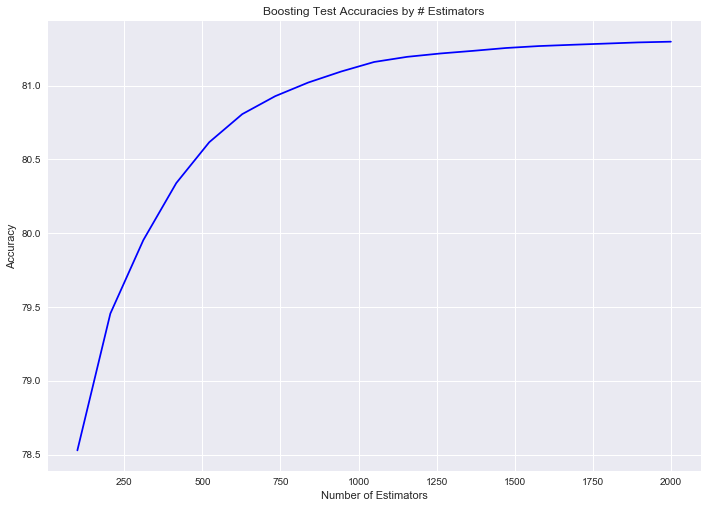

In [57]:
gradientTestScores=[]
gradientIters = np.linspace(100, 2000, 19, endpoint=True)
for i in range(100,2000,100):
    est = GradientBoostingRegressor(n_estimators=i, max_depth=1, learning_rate=.1)
    est.fit(Train_X, Train_Y)
    gradientTestScores.append(est.score(Test_X, Test_Y)*100)
plt.plot(gradientIters,gradientTestScores,'b', label="Testing")
plt.title("Boosting Test Accuracies by # Estimators")
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.show()
plt.figure()

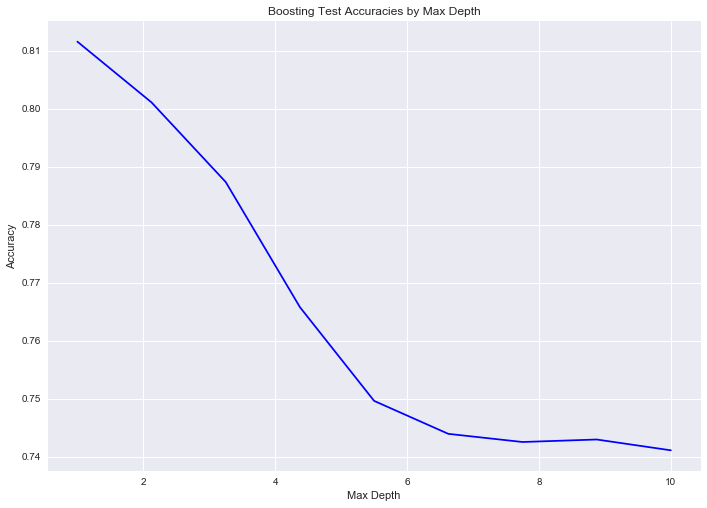

In [58]:
gradientTestScores=[]
gradientIters = np.linspace(1, 10, 9, endpoint=True)
for i in range(1,10,1):
    est = GradientBoostingRegressor(n_estimators=1000, max_depth=i, learning_rate=.1)
    est.fit(Train_X, Train_Y)
    gradientTestScores.append(est.score(Test_X, Test_Y))
plt.plot(gradientIters,gradientTestScores,'b', label="Testing")
plt.title("Boosting Test Accuracies by Max Depth")
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.show()
plt.figure()

Accuracy scores with 1000 estimators, max depth of 1, and learning rate of .1:
 - Non CV scores:  0.811599288091
 - Cross Validated Accuracy : -26.89% (+/- 107.58%)


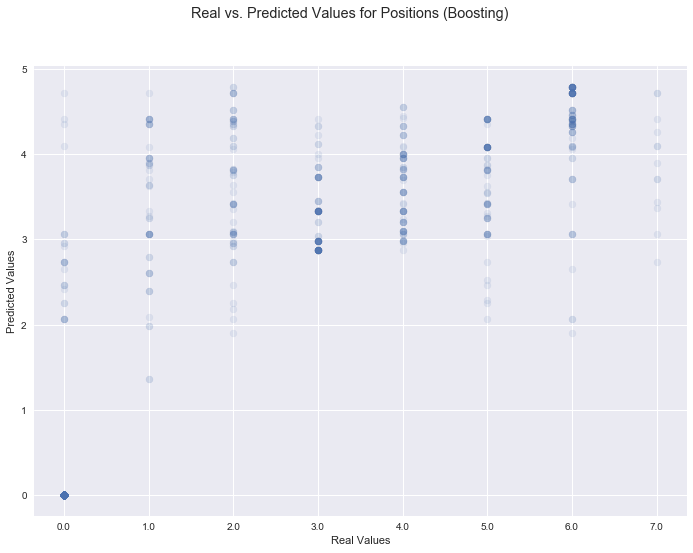

In [59]:
est = GradientBoostingRegressor(n_estimators=1000, max_depth=1, learning_rate=.1)
est.fit(Train_X, Train_Y)
predictedVals = est.predict(Test_X);
plt.scatter(Test_Y, predictedVals, alpha = .1)
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.suptitle("Real vs. Predicted Values for Positions (Boosting)")
print "Accuracy scores with 1000 estimators, max depth of 1, and learning rate of .1:"
print " - Non CV scores: ",est.score(Test_X, Test_Y)
scores = cross_val_score(est, Test_X, Test_Y, cv=5)
print(" - Cross Validated Accuracy : %0.2f%% (+/- %0.2f%%)" % (scores.mean()*100, (scores.std() * 2)*100))

# Gradient Boosting Interpretation

Gradient boosting was the 3rd most accurate model used to predict with our data. The accuracy increased when the number of estimators was increased before fitting, but decreased when the max depth or learning rate were increased. The maximum accuracy appears to be approximately 80.6% which is deemed to be an acceptable accuracy rate for this project. As seen in the real vs. predicted values graph, this model seems to be quite good at predicting the quarterback (0), offensive line (3) and defensive line (4) positions, while only being an OK estimator for all other positions

C:\Users\Kevin\Anaconda2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Accuracy scores with Hinge type loss and L2 Norm Penalty:
 - Non CV scores:  0.900219298246
 - Cross Validated Accuracy : 89.21% (+/- 5.41%)


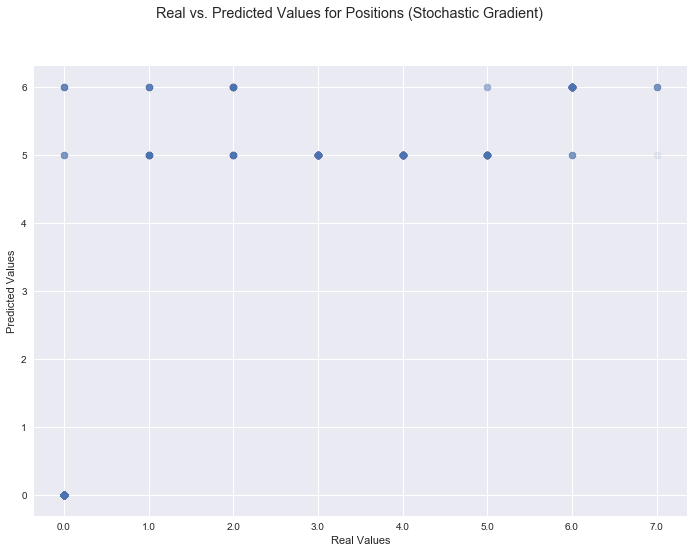

In [60]:
SGD = SGDClassifier(penalty="l2")
SGD1 = SGD.fit(Train_X, Train_Y)
predictedVals = SGD1.predict(Test_X);
plt.scatter(Test_Y, predictedVals, alpha = .1)
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.suptitle("Real vs. Predicted Values for Positions (Stochastic Gradient)")
print "Accuracy scores with Hinge type loss and L2 Norm Penalty:"
print " - Non CV scores: ",SGD1.score(Test_X, Test_Y)
scores = cross_val_score(SGD1, Test_X, Test_Y, cv=5)
print(" - Cross Validated Accuracy : %0.2f%% (+/- %0.2f%%)" % (scores.mean()*100, (scores.std() * 2)*100))

# Stochastic Gradient Descent Interpretation

This model, despite having a decently high accuracy score for both cross-validated and non CV scores seems to not be the best model for predictions given our data. The predicted vs actual values graph shows a good trent of real values matching their predicted counterparts, but all positions other than offensive and defensive line have a good chance of being incorrectly predicted as wide receivers. Quarterbacks are once again predicted well, showing that quarterbacks are often of one body type and have a specialized set of skills that no other positions have.

Accuracy scores with Hinge type loss and L2 Norm Penalty:
 - Non CV scores:  0.941337719298
 - Cross Validated Accuracy : 93.92% (+/- 2.81%)


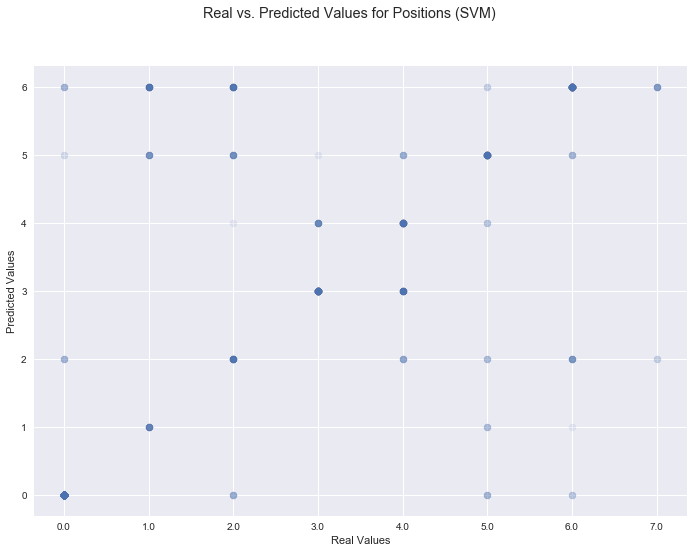

In [61]:
from sklearn import svm
SVM = svm.SVC(decision_function_shape='ovo')
SVM = SVM.fit(Train_X, Train_Y)  
predictedVals = SVM.predict(Test_X);
plt.scatter(Test_Y, predictedVals, alpha = .1)
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.suptitle("Real vs. Predicted Values for Positions (SVM)")
print "Accuracy scores with Hinge type loss and L2 Norm Penalty:"
print " - Non CV scores: ",SVM.score(Test_X, Test_Y)
scores = cross_val_score(SVM, Test_X, Test_Y, cv=5)
print(" - Cross Validated Accuracy : %0.2f%% (+/- %0.2f%%)" % (scores.mean()*100, (scores.std() * 2)*100))

# SVM Interpretation

This method of prediction also appears to be a good algorithm for predictions based on our data sets. Not only does it have a good CV score and non-CV score, it also shows a strong pattern of correct answers in the Real vs. Predicted position scatter plot. A strong point of this model is that it does a better job of not predicting a player to be a wide receiver when they aren't one. However, this model suffers where many other models are strong in that it incorrectly predicts QB's more than other models.

# Future Work
Future applications for this project would stem from the collection of more data. Scraping data from sites such as ESPN and NFL.com would allow us to have more complete data sets that we could run analysis on. Another portion of any future research would have to include breaking the statistics up based on the era a player played in. As time goes on, the rules in the NFL have evolved and the statistics have changed. For example, extra point kicks have been moved from the 3 yard line to the 15 yard line, which has resulted in fewer extra point kicks being made successfully.

Other biographical or biological data could also be gathered in the future such as muscle mass, BMI, vertical jump height, or 40 yard dash time. These statistics would serve as more potential features to base a successful career at a certain position on. These data types would also allow athletes to tune their bodies to concentrate more muscle in certain areas and could result in dietary changes to create an optimal environment to achieve these types of muscle gains.
 
# Workload Distribution

- Sam: Data cleaning, filtering, general pre-processing. EDA (correlation matrices, some boxplots). Aggregation of data both from files and into an overall final data frame. Implementation of Decision Tree algorithm, SVM, and Stochastic Gradient Descent algorithm. Graphing of accuracies for decision tree and gradient boosting algorithm accuracies. Development of powerpoint slides. Wrote all interpretations. Applied all cross validation techniques. Added actual vs. predicted charts for all algorithms. 

- Houston: Implementation of linear, logistic, and gradient boosting algorithms

- Kevin: EDA (Boxplots)

# Acknowledgements
Our data came from a data set found on www.kaggle.com. Most API’s came from the www.scikit-learn.com site.


# Differential Privacy
Privacy is violated when, using a summary statistic and two datasets that differ by a single row, and adversary is able to use the result of the statistic to differentiate between the two datasets. This can allow the adversary to know the information contained in that different row.
######  
A differentially private statistic would not leak any data just from the calculation of that statistic
The formal definition of a differentially private calculation A() is:

- | log( Prob[A(S) in Q] / Prob[A(S’) in Q] ) | ≤ epsilon
######  
Where S and S' are the two, differing datasets and Q is a set of possible values of A(). To maintain privacy, AS) and A(S') need to be "close" enough that the adversary cannot reliably distinguish between the two. Epsilon is a measure of that "closeness".


For our football player data, statistics that are easily senstive to privacy leaks are the players' heights and weights.
For ease of demonstrati0on, we'll take the mean of their heights

In [75]:
dpdf = df[['Height (inches)']].copy()
dpdf.rename(columns={'Height (inches)':'height'}, inplace=True)
#drop rows without height data
dfh1 = dpdf.query('height != 0')
print 'Mean height is:' 
print dfh1['height'].mean()

Mean height is:
74.0214797136


Knowing this dataset's mean, the adversary may try to calculate the mean of a new dataset with an additional player's height

In [77]:
dfh2 = dfh1.append({'height': 65}, ignore_index=True)
print 'New mean height is:' 
print dfh2['height'].mean()

New mean height is:
74.0178926441


Due to the side of the dataset, the the adversary may just look for a threshold of 74.02 inches, ie, if the mean is above it, he knows it is the first dataset, and if it is below, that it is the second. This can be combatted by adding noise to the returned mean.
######  
Noise from the Laplace distribution is similar to Gaussian noise, but generally perfroms better.

In [126]:
def noise(x, eps):
    amt = (1 / float(eps))
    x +=  np.random.laplace(0, amt, 1)
    return x

In [128]:
for i in range(1,5):
    print 'Iteration:'
    print i
    print 'New first mean height is:' 
    print noise(dfh1['height'].mean(), 500)
    print 'New second mean height is:' 
    print noise(dfh2['height'].mean(), 500)

Iteration:
1
New first mean height is:
[ 74.02103293]
New second mean height is:
[ 74.01700094]
Iteration:
2
New first mean height is:
[ 74.0265178]
New second mean height is:
[ 74.01010322]
Iteration:
3
New first mean height is:
[ 74.03005266]
New second mean height is:
[ 74.01881518]
Iteration:
4
New first mean height is:
[ 74.02164106]
New second mean height is:
[ 74.02366413]


With the added noise, the two returned means are much harder to distinguish between - in some cases, both are over the threshold of 74.02, and in some case, both are under. However, there are also cases where the mean for the second dataset is larger than the mean for the first, which should not be the case, as the additional entry was significantly below the first mean. This is a tradeoff for privacy - the accuracy of your results suffers.

In [132]:
for i in range(1,5):
    print 'Iteration:'
    print i
    print 'New first mean height is:' 
    print noise(dfh1['height'].mean(), 1000)
    print 'New second mean height is:' 
    print noise(dfh2['height'].mean(), 1000)

Iteration:
1
New first mean height is:
[ 74.01889461]
New second mean height is:
[ 74.01744662]
Iteration:
2
New first mean height is:
[ 74.0186438]
New second mean height is:
[ 74.01676397]
Iteration:
3
New first mean height is:
[ 74.02329001]
New second mean height is:
[ 74.01856349]
Iteration:
4
New first mean height is:
[ 74.02068074]
New second mean height is:
[ 74.01749579]


A smaller epsilon value indicates stricter privacy but less accuracy - for this data, a very large epsilon was needed to avoid degrading the data